In [285]:
from statsmodels.stats.multicomp import MultiComparison
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from statsmodels.stats.anova import AnovaRM
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.datasets import load_iris
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [286]:
SEED = 42
np.random.seed(SEED)

In [287]:
iris = load_iris(as_frame=True)

In [288]:
x = iris["data"]
y = iris["target"]

Separando conjunto de testes para report final

In [289]:
x.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [290]:
y.describe()

count    150.000000
mean       1.000000
std        0.819232
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        2.000000
Name: target, dtype: float64

In [291]:
x.isnull().sum()

sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
dtype: int64

Verificando a distribuição das classes

(array([50.,  0.,  0.,  0.,  0., 50.,  0.,  0.,  0., 50.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

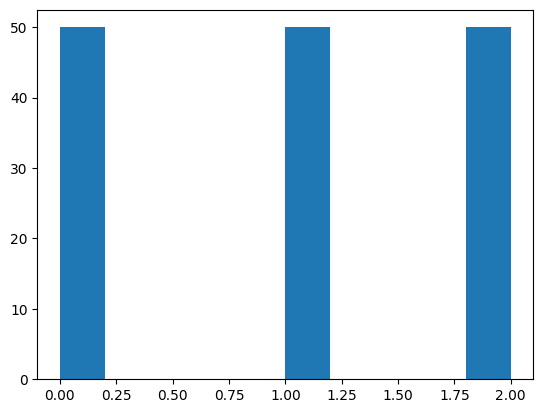

In [292]:
plt.hist(y)

<Axes: >

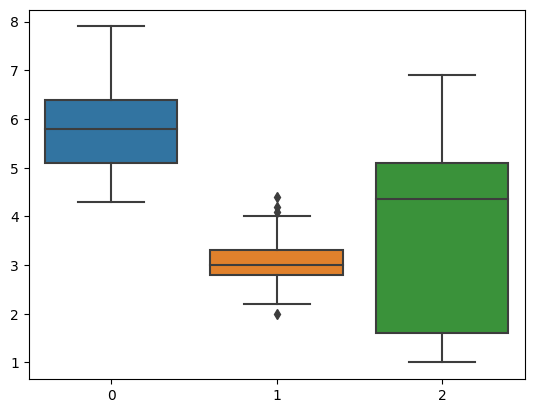

In [293]:
sns.boxplot([x["sepal length (cm)"], x["sepal width (cm)"], x["petal length (cm)"]])

In [294]:
x_train, x_test, y_train, y_test = train_test_split(x.values, y.values, test_size=.2, stratify=y, random_state=SEED)

## Seleção de métrica e amostragem

Existem 50 exemplos para cada classe, dessa forma, podemos utilizar a acurácia como métrica alvo.

Apesar das classes estarem distribuídas igualmente, existem poucas amostras, dessa forma, é melhor utilizar algum método de amostragem estratificado. Utilizaremos o K-fold estratificado

## Classificadores

Iremos comparar dois classificadores diferentes

In [295]:
def get_classifier1(complexity=1):
    return KNeighborsClassifier(n_neighbors=complexity)


def get_classifier2(complexity=1):
    return DecisionTreeClassifier(max_depth=complexity, random_state=SEED)


def get_classifier3():
    return LogisticRegression(random_state=SEED, max_iter=120)

## Treinando os classificadores

Avaliando o classificador 1 e encontrando a melhor complexidade

Evaluating classifier 1


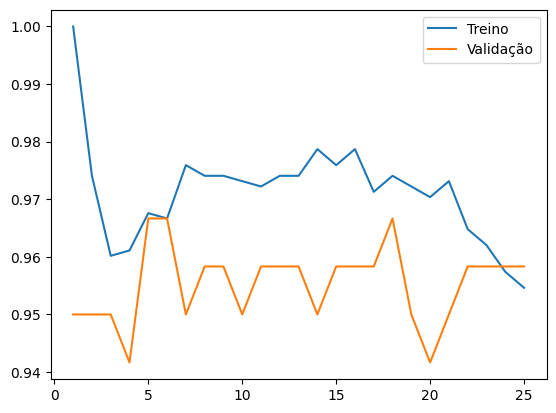

In [296]:
mean_train_acc = []
mean_val_acc = []

MIN_COMPLEXITY=1
MAX_COMPLEXITY=25

print(f"Evaluating classifier 1")
for curr_complexity in range(MIN_COMPLEXITY, MAX_COMPLEXITY + 1):
    cl = get_classifier1(curr_complexity)

    kf = KFold(n_splits=10, shuffle=True, random_state=SEED)
    kf.get_n_splits(x_train)
    train_acc = []
    val_acc = []

    for i, (train_index, val_index) in enumerate(kf.split(x_train)):

        X_train2, y_train2 = x_train[train_index], y_train[train_index]
        X_val, y_val = x_train[val_index], y_train[val_index]

        cl.fit(X_train2, y_train2)
        # Avaliar no treino
        y_pred = cl.predict(X_train2)
        acc = accuracy_score(y_train2, y_pred)
        train_acc.append(acc)
        # Avaliar na validação
        y_pred = cl.predict(X_val)
        acc = accuracy_score(y_val, y_pred)
        val_acc.append(acc)

    mean_train_acc.append(np.mean(train_acc))
    mean_val_acc.append(np.mean(val_acc))

x_fig = np.arange(MIN_COMPLEXITY, MAX_COMPLEXITY + 1)
plt.plot(x_fig, mean_train_acc, label="Treino")
plt.plot(x_fig, mean_val_acc, label="Validação")
plt.legend(loc="upper right")

In [297]:
df_results = pd.DataFrame({
    "Classificador": ["C1"] * MAX_COMPLEXITY,
    "Complexidade": list(range(MIN_COMPLEXITY, MAX_COMPLEXITY + 1)),
    "Acc Treino": mean_train_acc,
    "Acc Val": mean_val_acc,
})

df_results.head(10)

,Classificador,Complexidade,Acc Treino,Acc Val
0,C1,1,1.000000,0.950000
1,C1,2,0.974074,0.950000
2,C1,3,0.960185,0.950000
3,C1,4,0.961111,0.941667
4,C1,5,0.967593,0.966667
5,C1,6,0.966667,0.966667
6,C1,7,0.975926,0.950000
7,C1,8,0.974074,0.958333
8,C1,9,0.974074,0.958333
9,C1,10,0.973148,0.950000


Para o classificador 1, a complexidade 8 apresentou o melhor balanço entre viés e variância, dessa forma, seguiremos com este valor.

Avaliando o classificador 2

Evaluating classifier 2


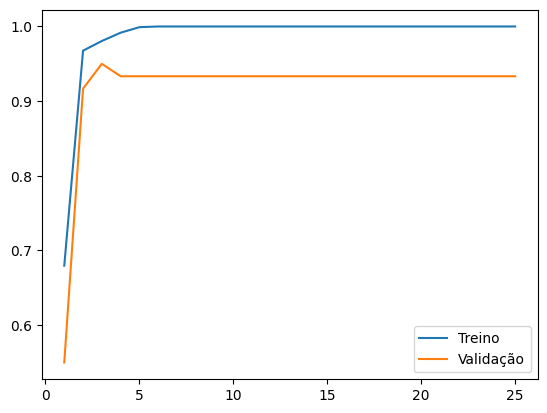

In [298]:
mean_train_acc = []
mean_val_acc = []

MIN_COMPLEXITY=1
MAX_COMPLEXITY=25


print(f"Evaluating classifier 2")
for curr_complexity in range(MIN_COMPLEXITY, MAX_COMPLEXITY + 1):
    cl = get_classifier2(curr_complexity)
        
    kf = KFold(n_splits=10, shuffle=True, random_state=SEED)
    kf.get_n_splits(x_train)
    train_acc = []
    val_acc = []
    for i, (train_index, val_index) in enumerate(kf.split(x_train)):
        X_train2, y_train2 = x_train[train_index], y_train[train_index]
        X_val, y_val = x_train[val_index], y_train[val_index]

        cl.fit(X_train2, y_train2)
        # Avaliar no treino
        y_pred = cl.predict(X_train2)
        acc = accuracy_score(y_train2, y_pred)
        train_acc.append(acc)
        # Avaliar na validação
        y_pred = cl.predict(X_val)
        acc = accuracy_score(y_val, y_pred)
        val_acc.append(acc)

    mean_train_acc.append(np.mean(train_acc))
    mean_val_acc.append(np.mean(val_acc))

x_fig = np.arange(MIN_COMPLEXITY, MAX_COMPLEXITY + 1)
plt.plot(x_fig, mean_train_acc, label="Treino")
plt.plot(x_fig, mean_val_acc, label="Validação")
plt.legend(loc="lower right")

In [299]:
df_results = pd.DataFrame({
    "Classificador": ["C2"] * MAX_COMPLEXITY,
    "Complexidade": list(range(MIN_COMPLEXITY, MAX_COMPLEXITY + 1)),
    "Acc Treino": mean_train_acc,
    "Acc Val": mean_val_acc,
})

df_results.head(10)

,Classificador,Complexidade,Acc Treino,Acc Val
0,C2,1,0.679630,0.550000
1,C2,2,0.967593,0.916667
2,C2,3,0.980556,0.950000
3,C2,4,0.991667,0.933333
4,C2,5,0.999074,0.933333
5,C2,6,1.000000,0.933333
6,C2,7,1.000000,0.933333
7,C2,8,1.000000,0.933333
8,C2,9,1.000000,0.933333
9,C2,10,1.000000,0.933333


Para o segundo classificador, a complexidade 3 apresentou o melhor desempenho na validação.

Avaliando o classificador 3 e encontrando a melhor complexidade

Evaluating classifier 3


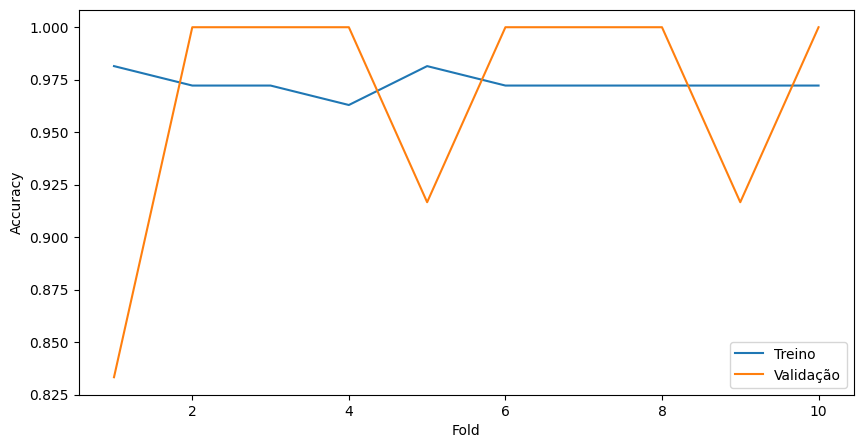

In [300]:
mean_train_acc = []
mean_val_acc = []

print(f"Evaluating classifier 3")
cl = get_classifier3()

kf = KFold(n_splits=10, shuffle=True, random_state=SEED)
kf.get_n_splits(x_train)
train_acc = []
val_acc = []
for i, (train_index, val_index) in enumerate(kf.split(x_train)):

    X_train2, y_train2 = x_train[train_index], y_train[train_index]
    X_val, y_val = x_train[val_index], y_train[val_index]

    cl.fit(X_train2, y_train2)
    # Avaliar no treino
    y_pred = cl.predict(X_train2)
    acc = accuracy_score(y_train2, y_pred)
    train_acc.append(acc)
    # Avaliar na validação
    y_pred = cl.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    val_acc.append(acc)

mean_train_acc.append(np.mean(train_acc))
mean_val_acc.append(np.mean(val_acc))

plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), train_acc, label="Treino")
plt.plot(range(1, 11), val_acc, label="Validação")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [301]:
df_results = pd.DataFrame({
    "Classificador": ["C3"],
    "Acc Treino": mean_train_acc,
    "Acc Val": mean_val_acc,
})

df_results

,Classificador,Acc Treino,Acc Val
0,C3,0.973148,0.966667


Para o terceiro classificador, a complexidade 3 apresentou o melhor desempenho na validação.

## Comparando os tres classificadores

In [325]:
data = {
    "Fold": [],
    "Modelo": [],
    "Val acc": [],
}

c1 = get_classifier1(8)
c2 = get_classifier2(3)
c3 = get_classifier3()

for model_name, cl in {
    "c1": c1,
    "c2": c2,
    "c3": c3,
}.items():
    kf = KFold(n_splits=10, shuffle=True, random_state=SEED)
    kf.get_n_splits(x_train)
    for i, (train_index, val_index) in enumerate(kf.split(x_train)):
        X_train2, y_train2 = x_train[train_index], y_train[train_index]
        X_val, y_val = x_train[val_index], y_train[val_index]

        cl.fit(X_train2, y_train2)
        # Avaliar na validação
        y_pred = cl.predict(X_val)
        acc = accuracy_score(y_val, y_pred)

        data["Fold"].append(i)
        data["Modelo"].append(model_name)
        data["Val acc"].append(acc)

df_results = pd.DataFrame(data)
display(df_results.groupby("Modelo").mean())

stat, p = ttest_rel(df_results[df_results["Modelo"] == "c1"]["Val acc"], df_results[df_results["Modelo"] == "c2"]["Val acc"])
print('Statistics=%.3f, p=%.3f' % (stat, p))

# Saída
alpha = 0.05
if p > alpha:
	print('As distribuições são iguais (falha ao rejeitar H_0)')
else:
	print('As distribuições são diferentes! (rejeitar H_0)')

,Fold,Val acc
Modelo,,
c1,4.5,0.958333
c2,4.5,0.950000
c3,4.5,0.966667


Statistics=0.557, p=0.591
As distribuições são iguais (falha ao rejeitar H_0)


In [303]:
df_results.head()

,Fold,Modelo,Val acc
0,0,c1,0.916667
1,1,c1,1.000000
2,2,c1,1.000000
3,3,c1,0.916667
4,4,c1,0.916667


In [326]:
anova = AnovaRM(data=df_results, depvar='Val acc', subject='Modelo', within=['Fold']).fit()
anova.summary()

,F Value,Num DF,Den DF,Pr > F
Fold,6.4894,9.0000,18.0000,0.0004


In [329]:
multi_comp = MultiComparison(df_results["Val acc"], df_results["Modelo"])
bonferroni_results = multi_comp.allpairtest(ttest_rel, method="bonferroni")
print(bonferroni_results[0])

means = df_results.groupby("Modelo").mean()
print(means)
diff = means.diff().dropna()
print(diff)

Test Multiple Comparison ttest_rel 
FWER=0.05 method=bonferroni
alphacSidak=0.02, alphacBonf=0.017
group1 group2   stat   pval  pval_corr reject
---------------------------------------------
    c1     c2  0.5571 0.5911       1.0  False
    c1     c3 -0.5571 0.5911       1.0  False
    c2     c3    -1.0 0.3434       1.0  False
---------------------------------------------
        Fold   Val acc
Modelo                
c1       4.5  0.958333
c2       4.5  0.950000
c3       4.5  0.966667
        Fold   Val acc
Modelo                
c2       0.0 -0.008333
c3       0.0  0.016667
